In [ ]:
import pickle
import numpy as np
import gc
import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, LSTM, Dropout, Conv2D, MaxPooling2D, BatchNormalization, TimeDistributed, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# File paths
mergedTrainFilePath = '/content/drive/MyDrive/merged_dats/merged_train_data4.dat'
mergedValFilePath = '/content/drive/MyDrive/merged_dats/merged_val_data.dat'
mergedTestFilePath = '/content/drive/MyDrive/merged_dats/merged_test_data.dat'

# Data Generator
class DataGenerator(Sequence):
    def __init__(self, file_path, batch_size=16):
        with open(file_path, "rb") as f:
            self.data = pickle.load(f)
        self.batch_size = batch_size
        self.indices = np.arange(len(self.data))
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch = [self.data[i] for i in batch_indices]
        x0_list, x1_list, x2_list, y_list = zip(*batch)
        return (
            np.stack(x0_list).astype(np.float16),
            np.stack(x1_list).astype(np.float16),
            np.stack(x2_list).astype(np.float16),
        ), np.stack(y_list).astype(np.float16)

batch_size = 32
train_generator = DataGenerator(mergedTrainFilePath, batch_size)
val_generator = DataGenerator(mergedValFilePath, batch_size)
test_generator = DataGenerator(mergedTestFilePath, batch_size)

del mergedTrainFilePath, mergedValFilePath, mergedTestFilePath
gc.collect()

# Audio Subnetwork
audio_input = Input(shape=(24, 1319, 1))
audio_model = Conv2D(32, kernel_size=(3,3), activation='relu')(audio_input)
audio_model = BatchNormalization()(audio_model)
audio_model = MaxPooling2D(pool_size=(2,2))(audio_model)
audio_model = Flatten()(audio_model)
audio_model = Dense(128, activation='relu')(audio_model)
audio_subnetwork = Model(inputs=audio_input, outputs=audio_model)

# Visual Subnetwork (Modified)
visual_input = Input(shape=(6, 128, 128, 3))

def build_frame_model():
    frame_input = Input(shape=(128, 128, 3))
    base_vgg = vgg16.VGG16(weights="imagenet", include_top=False, pooling='max')
    base_vgg.trainable = False
    output = base_vgg(frame_input)
    return Model(inputs=frame_input, outputs=output)

frame_model = build_frame_model()
processed_frames = TimeDistributed(frame_model)(visual_input)
encoded_vid = LSTM(64)(processed_frames)
visual_subnetwork = Model(inputs=visual_input, outputs=encoded_vid)

# Text Subnetwork
text_input = Input(shape=(768,))
text_model = Dense(128, activation='relu')(text_input)
text_model = Dropout(0.3)(text_model)
text_model = Dense(64, activation='relu')(text_model)
text_subnetwork = Model(inputs=text_input, outputs=text_model)

# Combined Network
combined = Concatenate()([audio_subnetwork.output, visual_subnetwork.output, text_subnetwork.output])
final1 = Dense(256, activation='relu')(combined)
final2 = Dense(5, activation='linear')(final1)
combined_network = Model(inputs=[audio_input, visual_input, text_input], outputs=final2)

# Compile
combined_network.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

# Train
early_stopping = EarlyStopping(patience=10)
history = combined_network.fit(train_generator,
                               validation_data=val_generator,
                               epochs=20,
                               verbose=1,
                               callbacks=[early_stopping])

del train_generator, val_generator
gc.collect()

# Evaluate
loss, mae = combined_network.evaluate(test_generator, verbose=0)
print(f'Test loss: {loss}')
print(f'1-MAE: {1 - mae}')


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 476ms/step - loss: 12.0919 - mae: 12.0919 - val_loss: 0.5725 - val_mae: 0.5725
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 447ms/step - loss: 0.9844 - mae: 0.9844 - val_loss: 0.3547 - val_mae: 0.3547
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 397ms/step - loss: 0.2617 - mae: 0.2617 - val_loss: 0.2596 - val_mae: 0.2596
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - loss: 0.1311 - mae: 0.1311 - val_loss: 0.2092 - val_mae: 0.2092
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 422ms/step - loss: 0.1227 - mae: 0.1227 - val_loss: 0.1445 - val_mae: 0.1445
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 407ms/step - loss: 0.1165 - mae: 0.1165 - val_loss: 0.1802 - val_mae: 0.1802
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 423ms/step - loss: 0.1110 - mae: 0.1110 - val_loss: 0.1261 - val_mae: 0.1261
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 404ms/step - loss: 0.1026 - mae: 0.1026 - val_loss: 0.1074 - val_mae: 0.1074
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 465m

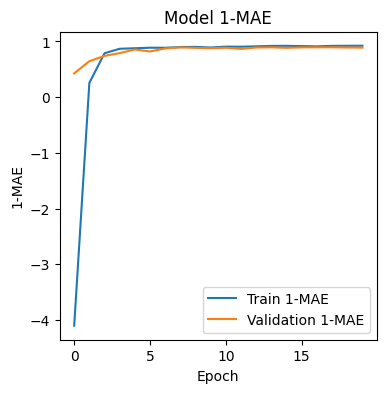

In [ ]:
one_minus_mae_train = [1-maee for maee in history.history['mae']]
one_minus_mae_val = [1-maee for maee in history.history['val_mae']]
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(one_minus_mae_train)
plt.plot(one_minus_mae_val)
plt.title('Model 1-MAE')
plt.ylabel('1-MAE')
plt.xlabel('Epoch')
plt.legend(['Train 1-MAE', 'Validation 1-MAE'], loc='lower right')

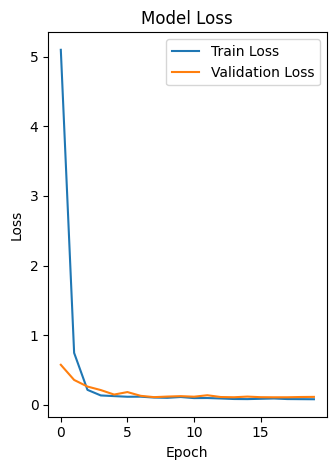

In [ ]:

plt.subplot(1,2,2) # Use the second subplot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()


In [ ]:
# Define the new model save path with .keras extension
model_save_path = "/content/drive/MyDrive/first_impressions_model.keras"

# Save the model in the new native Keras format
combined_network.save(model_save_path)

print(f"Model saved at: {model_save_path}")
